# Analyze & Build Model of Tweets to Predict Party Affiliation
## Data collected during 2016 Election Debates

In [108]:
import pandas as pd
import nltk
import seaborn as sns
import numpy as np

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

from sklearn import tree
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_selection import chi2
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline

from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest

from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support

In [78]:
tweets = pd.read_csv('tweets_debate1.csv')
users  = pd.read_csv('users.csv')

In [79]:
tweets.head(5)

,userID,text,created_at,favorite_count,followers_account,friends_count,location
0,11344,Police start the presidential debate memes swi...,09/26/2016 21:00:00 EDT,1,123,96,"East Point, GA"
1,2061,"RT @thereaIbanksy: become the most positive, e...",09/26/2016 21:00:03 EDT,481,116,244,"Kansas City, MO USA"
2,22644,This is gonna be a stressful ass week.,09/26/2016 21:00:03 EDT,9930,176,163,"Dundee, Oregon"
3,9694,RT @KevinBracken4: #serviceselfie #T2Trun NY M...,09/26/2016 21:00:12 EDT,8135,235,136,NY Metro
4,9087,RT @HillaryClinton: Let's do this. #DebateNigh...,09/26/2016 21:00:13 EDT,141,70,163,"New York, NY"


In [80]:
users.head(5)

,userID,state_code,party
0,1,AK,D
1,2,AK,D
2,3,AL,NaN
3,4,AL,NaN
4,5,AL,NaN


### Merge datasets on userID to add party code

In [81]:
df = pd.merge(tweets, users, on='userID')
df.head(5)

,userID,text,created_at,favorite_count,followers_account,friends_count,location,state_code,party
0,11344,Police start the presidential debate memes swi...,09/26/2016 21:00:00 EDT,1,123,96,"East Point, GA",GA,NaN
1,11344,Are these the new Pixel Phone and Chromecast c...,09/26/2016 22:30:00 EDT,1,123,96,"East Point, GA",GA,NaN
2,11344,Are these the new Pixel Phone and Chromecast c...,09/26/2016 22:30:00 EDT,1,127,96,"East Point, GA",GA,NaN
3,11344,Police start the presidential debate memes swi...,09/26/2016 21:00:00 EDT,1,127,96,"East Point, GA",GA,NaN
4,2061,"RT @thereaIbanksy: become the most positive, e...",09/26/2016 21:00:03 EDT,481,116,244,"Kansas City, MO USA",MO,NaN


In [82]:
df.shape

(23247, 9)

### Drop NAs

In [83]:
df = df.dropna()     # drop obs with NaN
df.head(5)

,userID,text,created_at,favorite_count,followers_account,friends_count,location,state_code,party
8,22644,This is gonna be a stressful ass week.,09/26/2016 21:00:03 EDT,9930,176,163,"Dundee, Oregon",OR,I
9,22644,RT @HeyyItsMikayla: Who needs Comedy Central w...,09/26/2016 21:28:18 EDT,9930,177,163,"Dundee, Oregon",OR,I
10,22644,RT @partyfessional: We're all gonna die #debat...,09/26/2016 21:40:33 EDT,9932,177,163,"Dundee, Oregon",OR,I
11,22644,RT @Zedd: You're a fool. https://t.co/OTuLaFazjh,09/26/2016 21:40:52 EDT,9933,177,163,"Dundee, Oregon",OR,I
12,22644,GOT HIS ASS BOI 🔥🔥🔥🔥 https://t.co/EMfnR7gmfg,09/26/2016 21:44:54 EDT,9935,177,163,"Dundee, Oregon",OR,I


In [84]:
df.shape

(14153, 9)

## Examine class Distribution

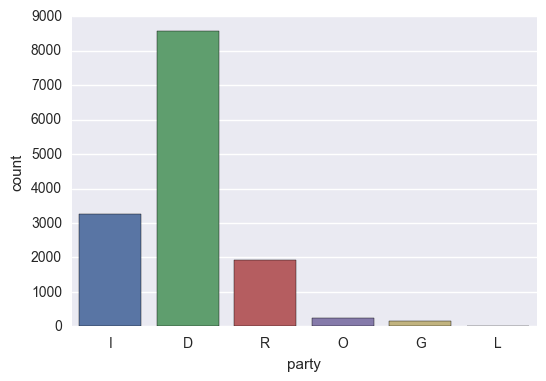

In [85]:
%matplotlib inline
sns.countplot(x="party", data=df)

#### Heavily unbalanced class distribution.  Will randomly drop some democrats to even out the distribution

In [135]:
#### Normalize class distribution

### Change O, G, and L labels to I
# Map party classes to numerical labels
## I: 1, D: 2, R: 3, O: 4, G: 5, L: 6
def changeLabels(party):
    if party == 'O':
        party = 'I'
    if party == 'G':
        party = 'I'
    if party == 'L':
        party = 'I'
    return party


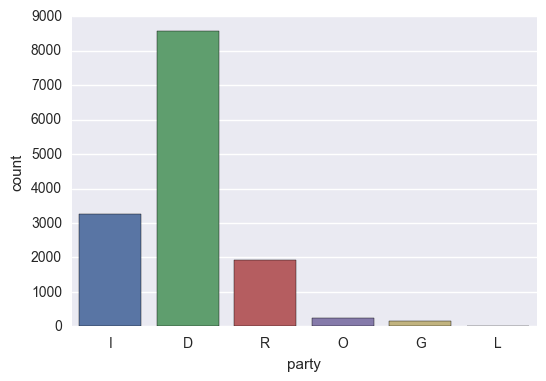

In [87]:
sns.countplot(x="party", data=df)

## Preprocess Data

In [88]:
def remove_stops(obs):
    stops = set(stopwords.words('english'))
    tokens = obs.apply(lambda x: [item for item in x if item not in stops])
    return tokens

def preprocess(df, remove_stopwords=True):
    obs = df.text.str.lower()
    obs = obs.str.strip()
    obs = obs.str.strip('""')
    obs = obs.apply(nltk.word_tokenize)

    if (remove_stopwords):
        obs = remove_stops(obs)

    obs = obs.str.join(' ')
    df['X'] = obs
    return obs

# Map party classes to numerical labels
## I: 1, D: 2, R: 3, O: 4, G: 5, L: 6
def getLabels(party):
    if party == 'I':
        label = 1
    if party == 'D':
        label = 2
    if party == 'R':
        label = 3
    if party == 'O':
        label = 4
    if party == 'G':
        label = 5
    if party == 'L':
        label = 6
    return label

In [136]:
df['X'] = preprocess(df, remove_stopwords=False)
# Reorder columns & drop created at
df = df.loc[:, ['X', 'text', 'favorite_count', 'followers_account', 'friends_count', 'location', 'state_code', 'party']]
df['label'] = df.party.apply(getLabels)

df['party'] = df.party.apply(changeLabels)

labels = df['party']
df.head(5)

,X,text,favorite_count,followers_account,friends_count,location,state_code,party,label
0,this is gon na be a stressful ass week .,This is gonna be a stressful ass week.,9930,176,163,"Dundee, Oregon",OR,I,1
1,rt @ heyyitsmikayla : who needs comedy central...,RT @HeyyItsMikayla: Who needs Comedy Central w...,9930,177,163,"Dundee, Oregon",OR,I,1
2,rt @ partyfessional : we 're all gon na die # ...,RT @partyfessional: We're all gonna die #debat...,9932,177,163,"Dundee, Oregon",OR,I,1
3,rt @ zedd : you 're a fool . https : //t.co/ot...,RT @Zedd: You're a fool. https://t.co/OTuLaFazjh,9933,177,163,"Dundee, Oregon",OR,I,1
4,got his ass boi 🔥🔥🔥🔥 https : //t.co/emfnr7gmfg,GOT HIS ASS BOI 🔥🔥🔥🔥 https://t.co/EMfnR7gmfg,9935,177,163,"Dundee, Oregon",OR,I,1


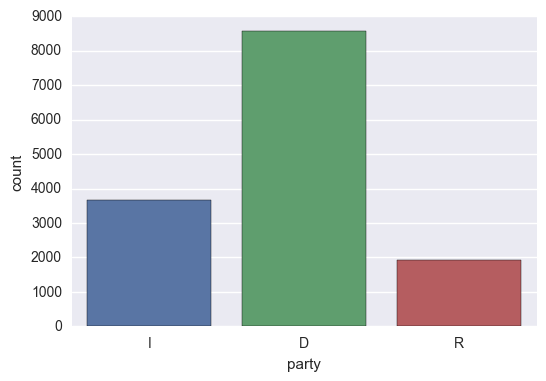

In [137]:
sns.countplot(x="party", data=df)

## Create Text Features

In [90]:
### DTM
def getDTM(features):
    vect = CountVectorizer()
    dtm = vect.fit_transform(features)
    return dtm
### DTM BI, Tri grams
def featuresByBagOfWordsBiTri(features):
    vect = CountVectorizer(ngram_range=(2, 3))
    dtm = vect.fit_transform(features)
    return dtm
### TF-IDF
def getDTMByTFIDF(features,nfeatures):
    tfIdf_vectorizer = TfidfVectorizer(max_features=nfeatures)
    dtm = tfIdf_vectorizer.fit_transform(features).toarray()
    return dtm,tfIdf_vectorizer
### Information Gain
def featuresByInformationGain(features,labels):
    treeCL = tree.DecisionTreeClassifier(criterion="entropy")
    treeCL = treeCL.fit(features,labels)
    transformed_features = SelectFromModel(treeCL,prefit=True).transform(features)
    return transformed_features
### Chi Squared
def featuresByChiSq(features,labels,nFeature=5000):
    chi2_model = SelectKBest(chi2,k=nFeature)
    dtm = chi2_model.fit_transform(features,labels)
    return dtm,chi2_model
### LSA
def featuresByLSA(features,ncomponents=100):
    svd = TruncatedSVD(n_components=ncomponents)
    normalizer =  Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)
    dtm_lsa = lsa.fit_transform(features)
    return dtm_lsa
### NMF

### Feature Selection

In [138]:
dtm = getDTM(df['X'])
bitriDtm = featuresByBagOfWordsBiTri(df['X'])
tfidfDtm, vect = getDTMByTFIDF(df['X'], None)

# the Information Gain, Chi Squared, & LSA features selection need a DTM
chisqDtm, chisqModel = featuresByChiSq(tfidfDtm,df['party'],2000)
igDtm = featuresByInformationGain(tfidfDtm,df['party'])
lsaDtm = featuresByLSA(dtm,100)

## Model

In [139]:
# return model precision, recall, fscore
def crossValidate(document_term_matrix,labels,classifier="SVM",nfold=3):
    clf = None
    precision = []
    recall = []
    fscore = []
    
    if classifier == "RF":
        clf = RandomForestClassifier()
    elif classifier == "NB":
        clf = MultinomialNB()
    elif classifier == "SVM":
        clf = LinearSVC()
    
    skf = StratifiedKFold(labels, n_folds=nfold)

    for train_index, test_index in skf:
        X_train, X_test = document_term_matrix[train_index], document_term_matrix[test_index]
        y_train, y_test = labels[train_index], labels[test_index]
        model = clf.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        p,r,f,s = precision_recall_fscore_support(y_test, y_pred, average='weighted')
        precision.append(p)
        recall.append(r)
        fscore.append(f)
        
    return np.mean(precision),np.mean(recall),np.mean(fscore)

In [174]:
models   = ['RF', 'SVM']
features = ['chisqDtm', 'igDtm','lsaDtm']
performance = ['precision', 'recall', 'fscore']

RF_perf = pd.DataFrame(index=performance, columns=features)
NB_perf = pd.DataFrame(index=performance, columns=features)
SVM_perf = pd.DataFrame(index=performance, columns=features)

lsa_perf = pd.DataFrame(index=performance, columns=models)
lsa_perf

,RF,SVM
precision,NaN,NaN
recall,NaN,NaN
fscore,NaN,NaN


#### Chisq DTM Performance

In [167]:
for model in models:
    prec, rec, fsc = crossValidate(chisqDtm, labels, model, 10)
    lsa_perf.set_value('precision', model, prec)
    lsa_perf.set_value('recall', model, rec)
    lsa_perf.set_value('fscore', model, fsc)
    
lsa_perf

,RF,SVM
precision,0.540309,0.608894
recall,0.586935,0.633642
fscore,0.540616,0.547956


#### LSA DTM Performance

In [165]:
for model in models:
    prec, rec, fsc = crossValidate(lsaDtm, labels, model, 10)
    lsa_perf.set_value('precision', model, prec)
    lsa_perf.set_value('recall', model, rec)
    lsa_perf.set_value('fscore', model, fsc)
    
lsa_perf

/Users/carrie/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,RF,SVM
precision,0.520857,0.445603
recall,0.578239,0.597753
fscore,0.528264,0.459066


#### Information Gain Model Performance

In [166]:
for model in models:
    prec, rec, fsc = crossValidate(igDtm, labels, model, 10)
    lsa_perf.set_value('precision', model, prec)
    lsa_perf.set_value('recall', model, rec)
    lsa_perf.set_value('fscore', model, fsc)
    
lsa_perf

,RF,SVM
precision,0.535682,0.498937
recall,0.59082,0.586162
fscore,0.539609,0.499727


In [ ]:
#### TF-IDF Performance

In [175]:
for model in models:
    prec, rec, fsc = crossValidate(tfidfDtm, labels, model, 10)
    lsa_perf.set_value('precision', model, prec)
    lsa_perf.set_value('recall', model, rec)
    lsa_perf.set_value('fscore', model, fsc)
    
lsa_perf

,RF,SVM
precision,0.540984,0.509455
recall,0.606786,0.558178
fscore,0.530949,0.520993


In [103]:
df['X'] = preprocess(df, remove_stopwords=False)
labels  = df['party']
df.head(3)

,X,text,favorite_count,followers_account,friends_count,location,state_code,party,label
0,this is gon na be a stressful ass week .,This is gonna be a stressful ass week.,9930,176,163,"Dundee, Oregon",OR,I,1
1,rt @ heyyitsmikayla : who needs comedy central...,RT @HeyyItsMikayla: Who needs Comedy Central w...,9930,177,163,"Dundee, Oregon",OR,I,1
2,rt @ partyfessional : we 're all gon na die # ...,RT @partyfessional: We're all gonna die #debat...,9932,177,163,"Dundee, Oregon",OR,I,1


In [105]:
dtm, vect = getDTMByTFIDF(df['X'], None)

In [106]:
chisqDtm, chisqModel = featuresByChiSq(dtm,labels,2000)

In [109]:
precision, recall, fscore = crossValidate(chisqDtm,labels,"SVM",10)
print("ChiSq Features:")
print(str(precision), str(recall), str(fscore))

/Users/carrie/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:552: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)
/Users/carrie/anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


ChiSq Features:
0.597383498192 0.635888129668 0.55314084808


# Word Cloud

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import PIL
from PIL import Image
import matplotlib.pyplot as plt

'''
Trump Twitter Word Cloud
Reference: https://github.com/amueller/word_cloud/blob/master/examples/simple.py
'''



def grey_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)

def strip_links(text):
    link_regex    = re.compile('((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)', re.DOTALL)
    links         = re.findall(link_regex, text)
    for link in links:
        text = text.replace(link[0], ', ')
    return text



# mask
mask = np.array(Image.open('img/trumpmask.png'))

# Generate a word cloud image
twittertrumpcloud = WordCloud(mask=mask, max_words=2000, stopwords=stopwords, margin=10,
               random_state=1).generate(speech)


# Get top 1000 words
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(lectures)
indices = np.argsort(vectorizer.idf_)[::-1]
features = vectorizer.get_feature_names()
top_n = 2
top_features = [features[i] for i in indices[:top_n]]
print top_features




twittertrumpcloud.generate(speech)

# store to file
twittertrumpcloud.to_file("twittertrumpcloud.png")
# store default colored image

default_colors = twittertrumpcloud.to_array()
plt.title("Trump Twitter Word Cloud")
plt.imshow(twittertrumpcloud.recolor(color_func=grey_color_func, random_state=3))
twittertrumpcloud.to_file("twitterttrumpcloud.png")

plt.imshow(twittertrumpcloud)
plt.axis("off")
plt.figure()
plt.imshow(alice_mask, cmap=plt.cm.gray)
plt.axis("off")
plt.show()


